In [1]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned_2018_Reading.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split

X = Taiwan_QQQ.drop(['Reading_level'], axis=1)
y = Taiwan_QQQ['Reading_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

RTSN          0.563668
RCUN          0.563457
RTML          0.560289
RCER          0.539371
RCLI          0.532124
                ...   
ST177Q01HA    0.030401
ST196Q02HA    0.030342
HEDRES        0.030317
ST207Q03HA    0.030263
ST150Q01IA    0.030117
Length: 100, dtype: float64


In [4]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,RTSN,RCUN,RTML,RCER,RCLI,GLCM,JOYREAD,METASPAM,ST165Q04IA,ST225Q06HA,...,ST217Q04HA,PARED,ST225Q02HA,ST023Q03TA,ICTHOME,ST177Q01HA,ST196Q02HA,HEDRES,ST207Q03HA,ST150Q01IA
571621,404.5217,375.1557,384.5323,407.8958,386.0565,453.4855,-0.6996,-1.41,3.0,0.0,...,2.0,14.0,1.0,3.0,6.0,1.0,4.0,-1.0118,1.0,2.0
568626,667.0569,654.8895,654.4704,639.8344,629.8557,683.6405,0.6380,0.42,4.0,1.0,...,2.0,16.0,0.0,4.0,6.0,4.0,3.0,-0.6122,3.0,4.0
572855,579.9832,577.5912,613.7438,607.1789,593.1064,624.6456,-2.7114,0.42,4.0,1.0,...,1.0,14.0,0.0,3.0,6.0,2.0,3.0,-1.2622,3.0,3.0
573892,316.2809,336.8350,361.7677,337.7383,361.5411,393.9244,-0.9615,-1.41,1.0,0.0,...,4.0,14.0,0.0,1.0,3.0,1.0,1.0,-4.4106,1.0,4.0
573109,533.3597,526.8344,527.9564,548.2182,518.4995,491.5303,1.4712,-0.04,4.0,1.0,...,3.0,14.0,0.0,3.0,6.0,1.0,1.0,-0.1357,2.0,4.0


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}

# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.9482312338222606
Fold 2 score: 0.9482312338222606
Fold 3 score: 0.9542709232096636
Fold 4 score: 0.9516824849007766
Fold 5 score: 0.9507772020725389
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5245901639344263
Fold 2 score: 0.5237273511647972
Fold 3 score: 0.5237273511647972
Fold 4 score: 0.5228645383951682
Fold 5 score: 0.5233160621761658
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.9352890422778257
Fold 2 score: 0.9292493528904228
Fold 3 score: 0.9352890422778257
Fold 4 score: 0.9309749784296808
Fold 5 score: 0.9360967184801382
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.9482312338222606
Fold 2 score: 0.9482312338222606
Fold 3 score: 0.9542709232096636
Fold 4 score: 0.9516824849007766
Fold 5 score: 0.9507772020725389
Params: {'svm

In [6]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]  # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.9499568593615185
Fold 2 score: 0.9568593615185504
Fold 3 score: 0.9577221742881795
Fold 4 score: 0.9594477998274374
Fold 5 score: 0.9525043177892919
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.9534081104400345
Fold 2 score: 0.9577221742881795
Fold 3 score: 0.9568593615185504
Fold 4 score: 0.9585849870578085
Fold 5 score: 0.9525043177892919
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.9525452976704055
Fold 2 score: 0.9577221742881795
Fold 3 score: 0.9568593615185504
Fold 4 score: 0.9594477998274374
Fold 5 score: 0.9542314335060449
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.9499568593615185
Fold 2 score: 0.955996548

In [7]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}

# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.9456427955133736
Fold 2 score: 0.9603106125970664
Fold 3 score: 0.9559965487489215
Fold 4 score: 0.9585849870578085
Fold 5 score: 0.9455958549222798
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.9473684210526315
Fold 2 score: 0.9603106125970664
Fold 3 score: 0.9568593615185504
Fold 4 score: 0.9603106125970664
Fold 5 score: 0.9455958549222798
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.9499568593615185
Fold 2 score: 0.9551337359792925
Fold 3 score: 0.9559965487489215
Fold 4 score: 0.9628990509059534
Fold 5 score: 0.9473229706390328
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.9456427955133736
Fold 2 score: 0.9603106125970664
Fold 3 scor

In [8]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j + 1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7963761863675582
Fold 2 score: 0.7463330457290768
Fold 3 score: 0.7722174288179465
Fold 4 score: 0.7877480586712683
Fold 5 score: 0.7495682210708118
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.8067299396031061
Fold 2 score: 0.7549611734253667
Fold 3 score: 0.7782571182053495
Fold 4 score: 0.7955133735979293
Fold 5 score: 0.7538860103626943
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.8050043140638481
Fold 2 score: 0.7549611734253667
Fold 3 score: 0.7782571182053495
Fold 4 score: 0.7937877480586712
Fold 5 score: 0.7538860103626943
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.8067299396031061
Fold 2 score: 0.7549611734253667
Fold 3 score: 0.7782571182053495
Fold 4 score: 0.7955133735979293
Fold 5 score: 0.7538860103626943
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.8067299396031061
Fold 2 score: 0.7549611734253667
Fold 3 score: 0.7782571182053495
Fold 4 score: 0.7946505608283002
Fold 5 score: 0.753886010362

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold

# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
rf_best_model.score(X_test, y_test)

0.9551414768806074

In [14]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

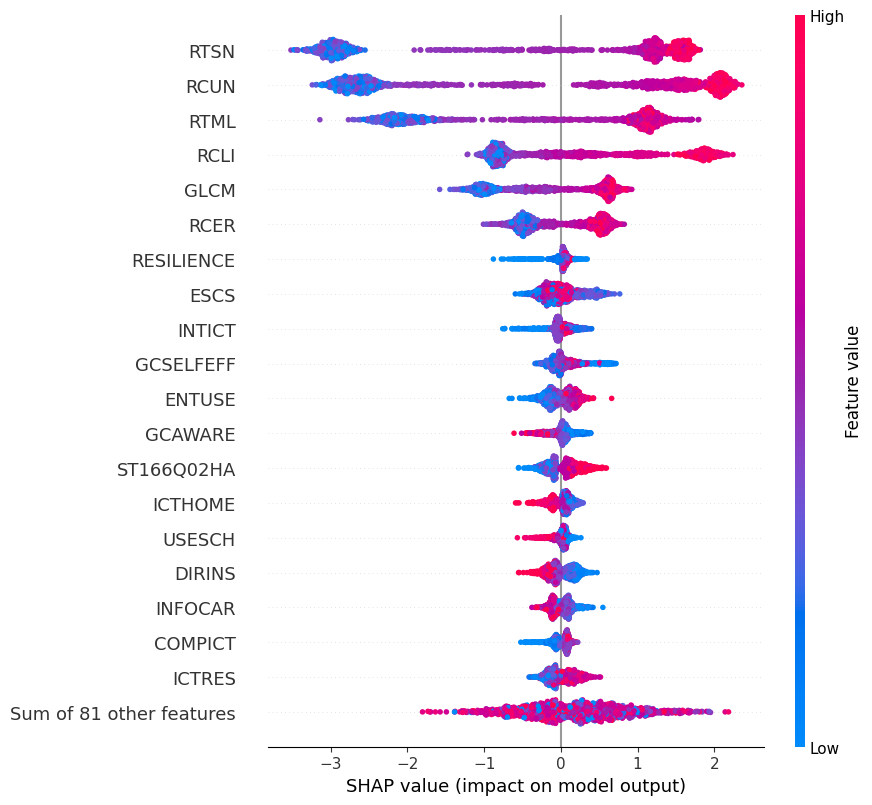

In [15]:
shap.plots.beeswarm(shap_values, max_display=20, order=shap_values.abs.max(0))

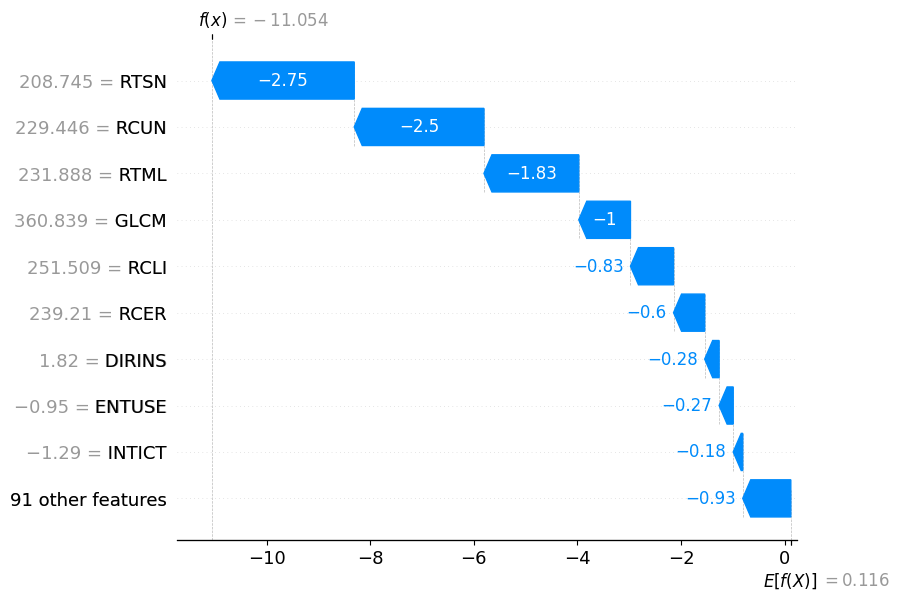

In [12]:
shap.plots.waterfall(shap_values[2])